In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt

from numpy.typing import NDArray
from pyod.models.knn import KNN
from pyod.utils.data import generate_data
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, roc_curve, auc
from scipy.linalg import cholesky

os.makedirs('images', exist_ok=True)

### Exercise 1

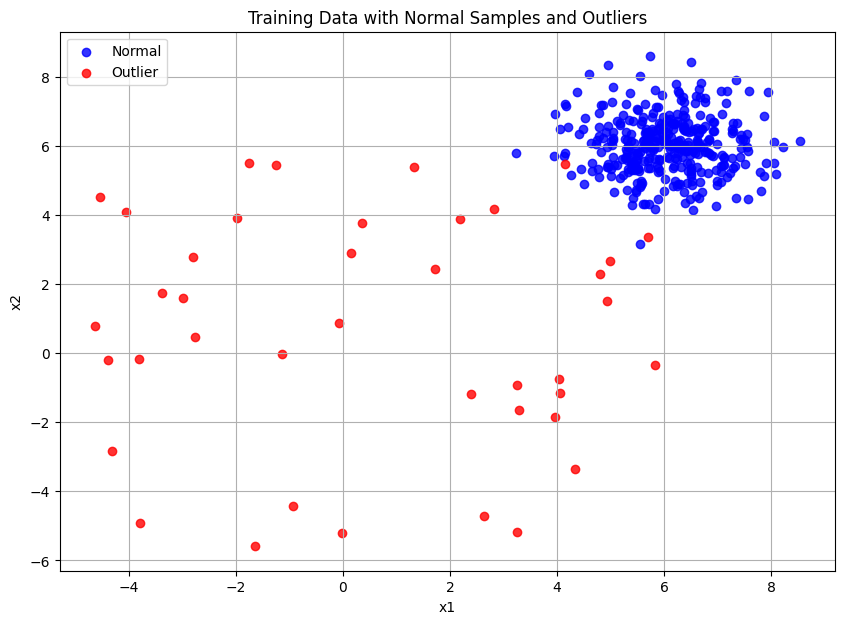

In [6]:
n_samples = 500
n_train = 400
n_test = 100
contamination = 0.1
n_features = 2

X_train, X_test, y_train, y_test = generate_data(
    n_train=n_train,
    n_test=n_test,
    n_features=n_features,
    contamination=contamination,
    random_state=42
)

plt.figure(figsize=(10, 7))
plt.scatter(X_train[y_train == 0, 0], 
           X_train[y_train == 0, 1], 
           c='blue', 
           label='Normal',
           alpha=0.8)
plt.scatter(X_train[y_train == 1, 0], 
           X_train[y_train == 1, 1], 
           c='red', 
           label='Outlier',
           alpha=0.8)

plt.title('Training Data with Normal Samples and Outliers')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.grid(True)
plt.show()

### Exercise 2

In [7]:
def display_confusion_matrix(y_true: NDArray[np.int_], y_pred: NDArray[np.int_]) -> None:
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    print(f"TN: {tn}, FP: {fp}")
    print(f"FN: {fn}, TP: {tp}")
    print(f"Balanced Accuracy: {balanced_accuracy_score(y_true, y_pred):.4f}")

=== Results with contamination = 0.1 ===
Training Data Confusion Matrix:
TN: 358, FP: 2
FN: 2, TP: 38
Balanced Accuracy: 0.9722

Test Data Confusion Matrix:
TN: 90, FP: 0
FN: 1, TP: 9
Balanced Accuracy: 0.9500

=== Results with contamination = 0.05 ===
TN: 90, FP: 0, FN: 5, TP: 5
Balanced Accuracy: 0.7500
AUC: 0.9644

=== Results with contamination = 0.15 ===
TN: 88, FP: 2, FN: 1, TP: 9
Balanced Accuracy: 0.9389
AUC: 0.9644

=== Results with contamination = 0.2 ===
TN: 85, FP: 5, FN: 1, TP: 9
Balanced Accuracy: 0.9222
AUC: 0.9644


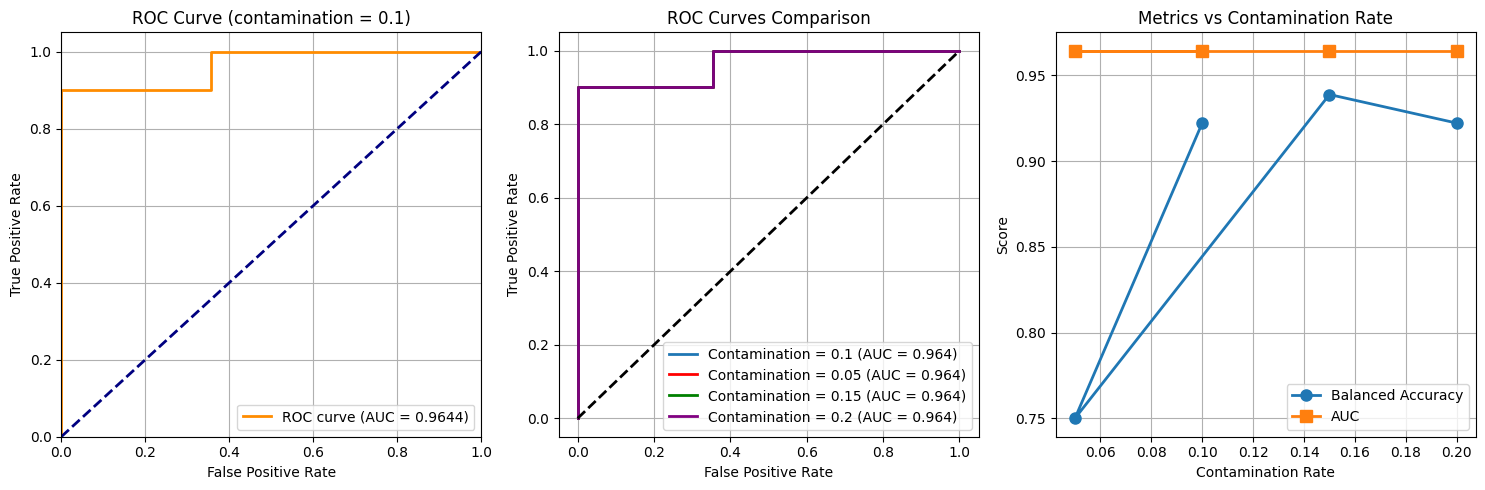


=== Summary Table ===
Contamination | Balanced Accuracy | AUC
----------------------------------------
       0.10 |          0.9222 | 0.9644
       0.05 |          0.7500 | 0.9644
       0.15 |          0.9389 | 0.9644
       0.20 |          0.9222 | 0.9644


In [8]:
knn_model = KNN(contamination=contamination)
knn_model.fit(X_train)

y_train_pred = knn_model.labels_
y_test_pred = knn_model.predict(X_test)

train_scores = knn_model.decision_scores_
test_scores = knn_model.decision_function(X_test)

print("=== Results with contamination =", contamination, "===")
print("Training Data Confusion Matrix:")
display_confusion_matrix(y_train, y_train_pred)
print("\nTest Data Confusion Matrix:")
display_confusion_matrix(y_test, y_test_pred)

fpr, tpr, thresholds = roc_curve(y_test, test_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (contamination = {contamination})')
plt.legend(loc="lower right")
plt.grid(True)

contamination_rates = [0.05, 0.15, 0.2]
results = []

for i, cont_rate in enumerate(contamination_rates):
    knn_model = KNN(contamination=cont_rate)
    knn_model.fit(X_train)
    
    y_test_pred = knn_model.predict(X_test)
    test_scores = knn_model.decision_function(X_test)
    
    cm_new = confusion_matrix(y_test, y_test_pred)
    tn_new, fp_new, fn_new, tp_new = cm_new.ravel()
    balanced_acc_new = balanced_accuracy_score(y_test, y_test_pred)
    
    fpr_new, tpr_new, _ = roc_curve(y_test, test_scores)
    roc_auc_new = auc(fpr_new, tpr_new)
    
    results.append({
        'contamination': cont_rate,
        'tn': tn_new, 'fp': fp_new, 'fn': fn_new, 'tp': tp_new,
        'balanced_accuracy': balanced_acc_new,
        'auc': roc_auc_new,
        'fpr': fpr_new, 'tpr': tpr_new
    })
    
    print(f"\n=== Results with contamination = {cont_rate} ===")
    print(f"TN: {tn_new}, FP: {fp_new}, FN: {fn_new}, TP: {tp_new}")
    print(f"Balanced Accuracy: {balanced_acc_new:.4f}")
    print(f"AUC: {roc_auc_new:.4f}")


plt.subplot(1, 3, 2)
plt.plot(fpr, tpr, label=f'Contamination = {contamination} (AUC = {roc_auc:.3f})', lw=2)
colors = ['red', 'green', 'purple']
for i, result in enumerate(results):
    plt.plot(result['fpr'], result['tpr'], 
             label=f"Contamination = {result['contamination']} (AUC = {result['auc']:.3f})", 
             color=colors[i], lw=2)
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
all_contaminations = [contamination] + [r['contamination'] for r in results]
all_balanced_acc = [balanced_accuracy_score(y_test, y_test_pred)] + [r['balanced_accuracy'] for r in results]
all_auc = [roc_auc] + [r['auc'] for r in results]

plt.plot(all_contaminations, all_balanced_acc, 'o-', label='Balanced Accuracy', linewidth=2, markersize=8)
plt.plot(all_contaminations, all_auc, 's-', label='AUC', linewidth=2, markersize=8)
plt.xlabel('Contamination Rate')
plt.ylabel('Score')
plt.title('Metrics vs Contamination Rate')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('images/ex2.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n=== Summary Table ===")
print("Contamination | Balanced Accuracy | AUC")
print("-" * 40)
print(f"{contamination:11.2f} | {balanced_accuracy_score(y_test, y_test_pred):15.4f} | {roc_auc:.4f}")
for result in results:
    print(f"{result['contamination']:11.2f} | {result['balanced_accuracy']:15.4f} | {result['auc']:.4f}")

### Exercise 3

Dataset shape: (1000, 1)
Number of outliers: 100.0 (10.0%)
Number of normal points: 900 (90.0%)

Dataset statistics:
Mean: 5.4296
Standard deviation: 2.3155
Z-scores range: [0.0003, 4.9307]

Z-score threshold (at 90th percentile): 0.9298
Number of points classified as anomalies: 100 (10.0%)

=== Z-score Method Results ===
TN: 871, FP: 29
FN: 29, TP: 71
Balanced Accuracy: 0.8389


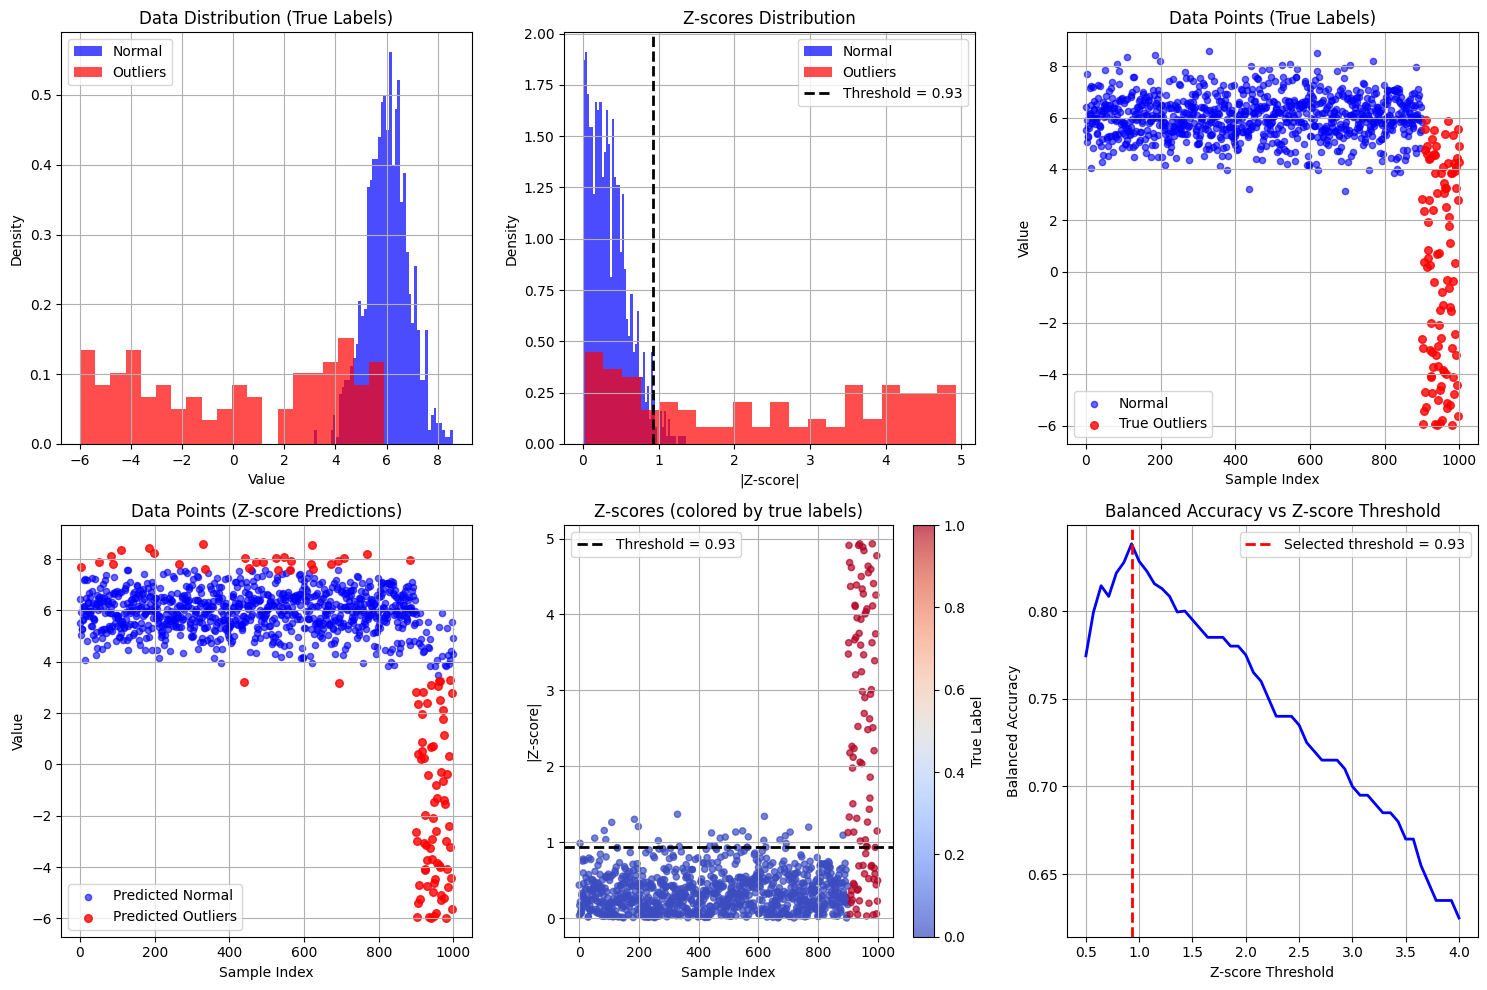


=== Testing Different Contamination Assumptions ===
Contamination  5%: threshold = 2.206, balanced accuracy = 0.7500
Contamination 10%: threshold = 0.930, balanced accuracy = 0.8389
Contamination 15%: threshold = 0.750, balanced accuracy = 0.8167
Contamination 20%: threshold = 0.650, balanced accuracy = 0.8167


In [9]:
n_train = 1000
n_test = 0
contamination = 0.1
n_features = 1

X_train, _, y_train, _ = generate_data(
    n_train=n_train,
    n_test=n_test,
    n_features=n_features,
    contamination=contamination,
    random_state=42
)

print(f"Dataset shape: {X_train.shape}")
print(f"Number of outliers: {sum(y_train)} ({sum(y_train)/len(y_train)*100:.1f}%)")
print(f"Number of normal points: {sum(y_train == 0)} ({sum(y_train == 0)/len(y_train)*100:.1f}%)")

X_1d = X_train.flatten()

mean = np.mean(X_1d)
std = np.std(X_1d)
z_scores = np.abs((X_1d - mean) / std)

print(f"\nDataset statistics:")
print(f"Mean: {mean:.4f}")
print(f"Standard deviation: {std:.4f}")
print(f"Z-scores range: [{z_scores.min():.4f}, {z_scores.max():.4f}]")

threshold_quantile = 1 - contamination
z_threshold = np.quantile(z_scores, threshold_quantile)

print(f"\nZ-score threshold (at {threshold_quantile*100:.0f}th percentile): {z_threshold:.4f}")

y_pred_zscore = (z_scores > z_threshold).astype(int)

print(f"Number of points classified as anomalies: {sum(y_pred_zscore)} ({sum(y_pred_zscore)/len(y_pred_zscore)*100:.1f}%)")

print(f"\n=== Z-score Method Results ===")
display_confusion_matrix(y_train, y_pred_zscore)

plt.figure(figsize=(15, 10))

# Plot 1: Data distribution
plt.subplot(2, 3, 1)
plt.hist(X_1d[y_train == 0], bins=50, alpha=0.7, label='Normal', color='blue', density=True)
plt.hist(X_1d[y_train == 1], bins=20, alpha=0.7, label='Outliers', color='red', density=True)
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Data Distribution (True Labels)')
plt.legend()
plt.grid(True)

# Plot 2: Z-scores distribution
plt.subplot(2, 3, 2)
plt.hist(z_scores[y_train == 0], bins=50, alpha=0.7, label='Normal', color='blue', density=True)
plt.hist(z_scores[y_train == 1], bins=20, alpha=0.7, label='Outliers', color='red', density=True)
plt.axvline(z_threshold, color='black', linestyle='--', linewidth=2, label=f'Threshold = {z_threshold:.2f}')
plt.xlabel('|Z-score|')
plt.ylabel('Density')
plt.title('Z-scores Distribution')
plt.legend()
plt.grid(True)

# Plot 3: Scatter plot with true labels
plt.subplot(2, 3, 3)
indices = np.arange(len(X_1d))
plt.scatter(indices[y_train == 0], X_1d[y_train == 0], c='blue', alpha=0.6, label='Normal', s=20)
plt.scatter(indices[y_train == 1], X_1d[y_train == 1], c='red', alpha=0.8, label='True Outliers', s=30)
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Data Points (True Labels)')
plt.legend()
plt.grid(True)

# Plot 4: Scatter plot with predicted labels
plt.subplot(2, 3, 4)
plt.scatter(indices[y_pred_zscore == 0], X_1d[y_pred_zscore == 0], c='blue', alpha=0.6, label='Predicted Normal', s=20)
plt.scatter(indices[y_pred_zscore == 1], X_1d[y_pred_zscore == 1], c='red', alpha=0.8, label='Predicted Outliers', s=30)
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Data Points (Z-score Predictions)')
plt.legend()
plt.grid(True)

# Plot 5: Z-scores vs sample index
plt.subplot(2, 3, 5)
plt.scatter(indices, z_scores, c=y_train, cmap='coolwarm', alpha=0.7, s=20)
plt.axhline(z_threshold, color='black', linestyle='--', linewidth=2, label=f'Threshold = {z_threshold:.2f}')
plt.xlabel('Sample Index')
plt.ylabel('|Z-score|')
plt.title('Z-scores (colored by true labels)')
plt.colorbar(label='True Label')
plt.legend()
plt.grid(True)

# Plot 6: Comparison of different thresholds
plt.subplot(2, 3, 6)
thresholds = np.linspace(0.5, 4, 50)
accuracies = []

for thresh in thresholds:
    y_pred_temp = (z_scores > thresh).astype(int)
    acc = balanced_accuracy_score(y_train, y_pred_temp)
    accuracies.append(acc)

plt.plot(thresholds, accuracies, 'b-', linewidth=2)
plt.axvline(z_threshold, color='red', linestyle='--', linewidth=2, 
            label=f'Selected threshold = {z_threshold:.2f}')
plt.xlabel('Z-score Threshold')
plt.ylabel('Balanced Accuracy')
plt.title('Balanced Accuracy vs Z-score Threshold')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('images/ex3.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n=== Testing Different Contamination Assumptions ===")
contamination_rates = [0.05, 0.10, 0.15, 0.20]

for cont_rate in contamination_rates:
    threshold_q = 1 - cont_rate
    z_thresh = np.quantile(z_scores, threshold_q)
    y_pred = (z_scores > z_thresh).astype(int)
    bal_acc = balanced_accuracy_score(y_train, y_pred)
    
    print(f"Contamination {cont_rate*100:2.0f}%: threshold = {z_thresh:.3f}, balanced accuracy = {bal_acc:.4f}")

### Exercise 4

Custom parameters:
Mean vector μ = [0.37454012 0.95071431 0.73199394]
Covariance matrix Σ =
[[0.35839198 0.03477225 0.42389366]
 [0.03477225 0.75363482 0.05895721]
 [0.42389366 0.05895721 1.44251562]]
Cholesky decomposition L =
[[0.59865848 0.         0.        ]
 [0.05808361 0.86617615 0.        ]
 [0.70807258 0.02058449 0.96990985]]

Generated dataset shape: (1000, 3)
Sample mean: [0.40135846 0.99825178 0.75681411]
Sample covariance:
[[0.34558818 0.02416427 0.4176218 ]
 [0.02416427 0.70970374 0.00876036]
 [0.4176218  0.00876036 1.46256717]]

Z-scores statistics:
Mean: 2.9301
Std: 2.4204
Range: [0.0400, 20.0172]

Z-scores threshold (at 90th percentile): 6.0359
Points classified as anomalies: 100 (10.0%)

=== Z-Scores Method Results ===
TN: 900, FP: 100
FN: 0, TP: 0
Balanced Accuracy: 0.9000


/home/vl4dio4n/UniBuc/Master/Anul 1/AD/Laboratoare/Lab01/ad-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


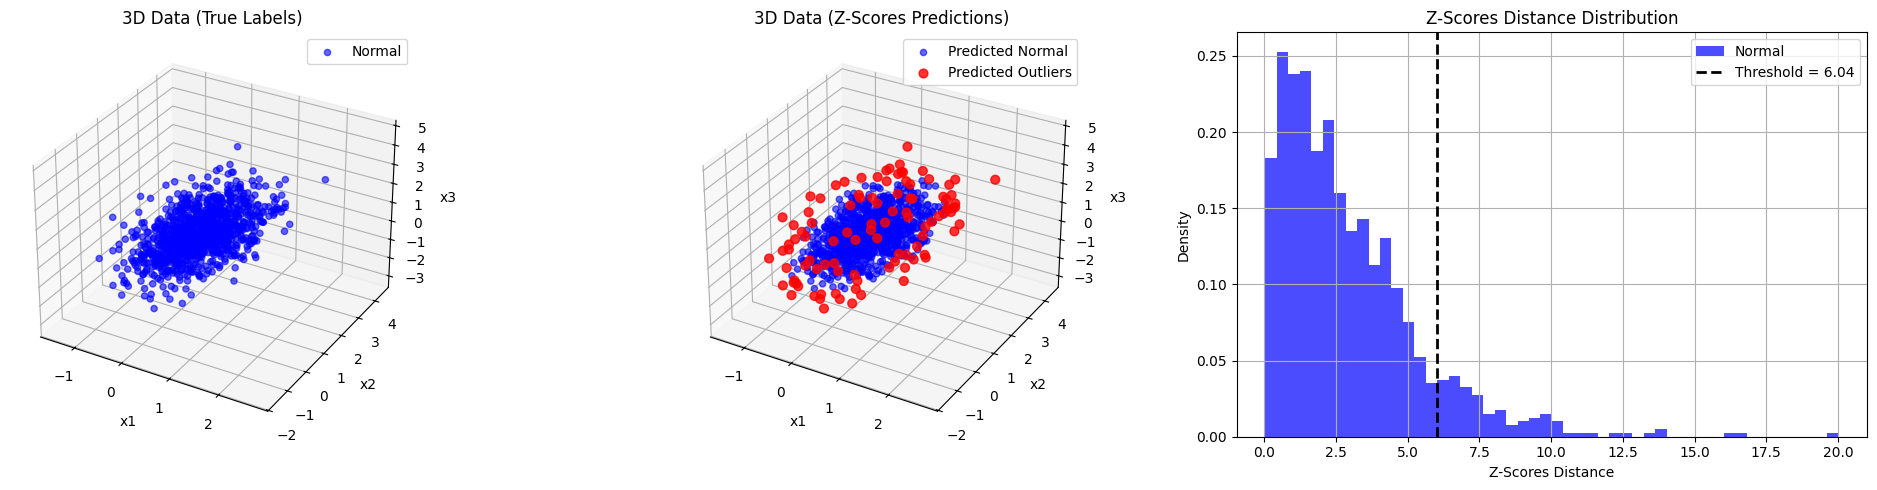

In [10]:
n_samples = 1000
contamination = 0.1
n_features = 3
random_state = 42
np.random.seed(random_state)

mu = np.random.random(n_features)
L = np.random.random(size=(n_features, n_features))
for i in range(n_features):
    L[i, i + 1:] = 0.0
sigma = L @ L.T

print("Custom parameters:")
print(f"Mean vector μ = {mu}")
print(f"Covariance matrix Σ =")
print(sigma)
print(f"Cholesky decomposition L =")
print(L)


X_standard = np.random.multivariate_normal(
    mean=np.zeros(n_features), 
    cov=np.eye(n_features), 
    size=n_samples)

Y = (L @ X_standard.T).T + mu

print(f"\nGenerated dataset shape: {Y.shape}")
print(f"Sample mean: {np.mean(Y, axis=0)}")
print(f"Sample covariance:")
print(np.cov(Y.T))

z_scores = np.zeros(n_samples)
for i in range(n_samples):
    z = Y[i, :] - mu
    t = np.linalg.solve(L, z)
    w = np.linalg.solve(L.T, t)
    z_scores[i] = z @ w

print(f"\nZ-scores statistics:")
print(f"Mean: {np.mean(z_scores):.4f}")
print(f"Std: {np.std(z_scores):.4f}")
print(f"Range: [{z_scores.min():.4f}, {z_scores.max():.4f}]")

threshold_quantile = 1 - contamination
z_scores_threshold = np.quantile(z_scores, threshold_quantile)

print(f"\nZ-scores threshold (at {threshold_quantile*100:.0f}th percentile): {z_scores_threshold:.4f}")

y_true = np.zeros(n_samples)
y_pred = (z_scores > z_scores_threshold).astype(int)

print(f"Points classified as anomalies: {sum(y_pred)} ({sum(y_pred)/len(y_pred)*100:.1f}%)")
print(f"\n=== Z-Scores Method Results ===")
display_confusion_matrix(y_true, y_pred)


fig = plt.figure(figsize=(20, 5))

# Plot 1: 3D scatter plot with true labels
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax1.scatter(Y[:, 0], Y[:, 1], Y[:, 2], 
           c='blue', alpha=0.6, s=20, label='Normal')
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_zlabel('x3')
ax1.set_title('3D Data (True Labels)')
ax1.legend()

# Plot 2: 3D scatter plot with predicted labels
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax2.scatter(Y[y_pred == 0, 0], Y[y_pred == 0, 1], Y[y_pred == 0, 2], 
           c='blue', alpha=0.6, s=20, label='Predicted Normal')
ax2.scatter(Y[y_pred == 1, 0], Y[y_pred == 1, 1], Y[y_pred == 1, 2], 
           c='red', alpha=0.8, s=40, label='Predicted Outliers')
ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
ax2.set_zlabel('x3')
ax2.set_title('3D Data (Z-Scores Predictions)')
ax2.legend()

# Plot 3: Z-Scores distances distribution
plt.subplot(1, 3, 3)
plt.hist(z_scores, bins=50, alpha=0.7, label='Normal', color='blue', density=True)
plt.axvline(z_scores_threshold, color='black', linestyle='--', linewidth=2, 
           label=f'Threshold = {z_scores_threshold:.2f}')
plt.xlabel('Z-Scores Distance')
plt.ylabel('Density')
plt.title('Z-Scores Distance Distribution')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('images/ex4.png', dpi=300, bbox_inches='tight')
plt.show()
